# Import variants VCF file

In [47]:
import numpy as np
import pandas as pd
import allel

In [1]:
vcf = allel.read_vcf("../data/raw/1349 sample and all 253k unfiltered SNPs.vcf")

In [2]:
vcf.keys()

dict_keys(['samples', 'calldata/GT', 'variants/ALT', 'variants/CHROM', 'variants/FILTER_PASS', 'variants/ID', 'variants/POS', 'variants/QUAL', 'variants/REF'])

In [49]:
variants = np.char.array(vcf["variants/CHROM"].astype(str)) + ":" + np.char.array(vcf["variants/POS"].astype(str))

In [7]:
mutations = vcf["calldata/GT"]
mutations = np.abs(mutations)
mutations = mutations.sum(axis=2)
mutations = mutations.T
mutations.shape

(1349, 253708)

In [50]:
mutations_df = pd.DataFrame(data=mutations, index=vcf["samples"], columns=variants)
mutations_df

,1:173152297,1:173152373,1:173152373,1:173152425,1:173152442,1:173152471,1:173152481,1:173152510,1:173152582,1:173152671,...,X:153386702,X:153386723,X:153386738,X:153386913,X:153387055,X:153387062,X:153387153,X:153387218,X:153387377,X:153387398
Betty_Ill_4901_2,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
ucl223ILL1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Betty_Ill_3822_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CKG1996ILL1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Betty_Ill_5103_2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57739,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1561,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2546,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
686-1,0,0,0,0,0,0,0,0,0,0,...,2,2,2,0,2,2,2,2,2,2


# Subset variants by gene

In [64]:
variants_top56_genes = pd.read_table("../data/interim/variants_top56_genes.csv", sep=",")
variants_top56_genes = variants_top56_genes.filter(items=["Gene(s)", "Variant ID"])

In [66]:
variants_top56_genes.set_index("Variant ID", inplace=True)

In [58]:
genes_matched_variants = mutations_df.columns & variants_top56_genes["Variant ID"]

In [69]:
mutations_df.T

,Betty_Ill_4901_2,ucl223ILL1,Betty_Ill_3822_2,CKG1996ILL1,Betty_Ill_5103_2,Betty_Ill_1045_2,Betty_Ill_4595_2,Betty_Ill_4763_2,Betty_Ill_4086_2,IS0210-1ILL1,...,1624,28289,80259,lgs102938,285,57739,1561,2546,686-1,40007
1:173152297,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1:173152373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1:173152373,2,0,0,1,1,0,0,2,0,1,...,1,2,1,0,1,1,0,0,0,0
1:173152425,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1:173152442,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X:153387062,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
X:153387153,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
X:153387218,1,1,0,1,1,0,0,2,0,1,...,1,1,1,0,0,0,1,0,2,2
X:153387377,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0


In [73]:
mutations_gene_matched = mutations_df.T.join(variants_top56_genes, how="right")

In [76]:
mutations_gene_gb = mutations_gene_matched.groupby("Gene(s)")

In [137]:
mutations_by_gene = {}
for x in mutations_gene_gb.groups:
    mutations_gene_df = mutations_gene_gb.get_group(x)
    gene_name = mutations_gene_df["Gene(s)"].iloc[0]
    print(gene_name)
    mutations_gene_df = mutations_gene_df.drop(columns=["Gene(s)"]).dropna(axis=0).T
    mutations_gene_df.to_csv("../data/processed/SNPs_by_gene/"+gene_name+".csv")
    mutations_by_gene[gene_name] = mutations_gene_df

BANK1
BIK
BLK
BTNL2
CDHR5
CEP70
CHD7
CNTNAP2
DAP
DAPK1
DSCAM
DSCAML1
ETS1
FAIM
GSDMB
HLA-DOB
HLA-DQA1
HLA-DQA2
HLA-DQB1
HLA-DQB2
HLA-DRA
HLA-DRB1
HLA-DRB5
ICA1
ICAM1
IKZF3
IRF5
IRF8
ITGAM
ITGAX
MECP2
NMNAT2
PHRF1
PRDM1
PXK
RAVER1
ROBO3
ROBO4
SCUBE1
SMG7
STAT4
TAP2
TLR7
TNFAIP3
TNFRSF13B
TNFSF4
TNIP1
TNPO3
TSPO
TTLL12
TYK2
UBE2L3
XKR6


# Gene - mutations

In [93]:
variant_genes = pd.read_table("../data/raw/216k Variants with gene name.csv", sep=",")
variant_genes

/Users/jonny/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Variant,Chromosome,Position,Reference,Alternate,Identifier,Classification,Priority,Gene(s),Transcripts(s),HGVS Description
0,1:173152297-SNV,1,173152297,G,C,NaN,Downstream,2,TNFSF4,"NM_001297562.1, NM_003326.4",g.173152297G>C
1,1:173152373-SNV,1,173152373,C,G,rs112986214,Downstream,2,TNFSF4,"NM_001297562.1, NM_003326.4",g.173152373C>G
2,1:173152374-Ins,1,173152374,-,AGAAAG,rs10644515,Downstream,2,TNFSF4,"NM_001297562.1, NM_003326.4",g.173152373_173152374insAGAAAG
3,1:173152442-SNV,1,173152442,C,T,NaN,Downstream,2,TNFSF4,"NM_001297562.1, NM_003326.4",g.173152442C>T
4,1:173152471-SNV,1,173152471,G,T,NaN,Downstream,2,TNFSF4,"NM_001297562.1, NM_003326.4",g.173152471G>T
...,...,...,...,...,...,...,...,...,...,...,...
216485,X:153387062-SNV,X,153387062,C,G,NaN,Intergenic,1,?,?,g.153387062C>G
216486,X:153387153-SNV,X,153387153,G,C,NaN,Intergenic,1,?,?,g.153387153G>C
216487,X:153387218-SNV,X,153387218,T,G,rs6655245,Intergenic,1,?,?,g.153387218T>G
216488,X:153387377-SNV,X,153387377,G,A,NaN,Intergenic,1,?,?,g.153387377G>A


# Run PCA

In [201]:

def get_top_k_components(snp_data, var_threshold=0.80, return_fit_transform=False):
    pca = PCA()
    pca.fit(snp_data)
    top_k = np.argmax(np.cumsum(pca.singular_values_) / np.sum(pca.singular_values_) > var_threshold)

    if return_fit_transform:
        pca.n_components = top_k
        pca.n_components_ = top_k
        print("top_k", top_k)
        return pca.transform(snp_data)
    else:
        return pca.components_[:top_k]

def get_top_variant_by_coef(pca_components, coef_percentile=70):
    gene_coefs_sum = np.abs(pca_components).sum(axis=0)
    coefs_percentile = np.percentile(gene_coefs_sum, coef_percentile)
    return np.where(gene_coefs_sum > coefs_percentile)

def select_top_variants(snp_data, var_threshold=0.80, coef_percentile=70):
    variants = snp_data.columns
    top_k_components = get_top_k_components(snp_data, var_threshold)
    top_variants_idx = get_top_variant_by_coef(top_k_components, coef_percentile)

    return variants[top_variants_idx]

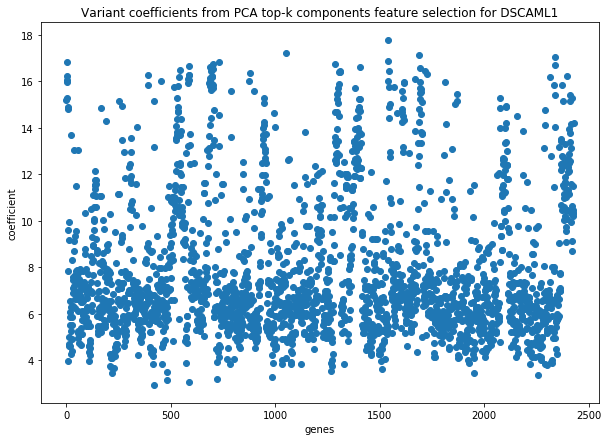

In [190]:
plt.figure(figsize=(10, 7))
plt.title("Variant coefficients from PCA top-k components feature selection for "+gene)
plt.ylabel("coefficient")
plt.xlabel("genes")
plt.scatter(x=range(pca.components_.shape[1]), y=gene_coefs_sum)

# Select variants by percentile

In [172]:
top_variants_by_gene = {}
for gene in mutations_by_gene.keys():
    top_variants_by_gene[gene] = select_top_variants(mutations_by_gene[gene], var_threshold=0.80, coef_percentile=70)
    print(gene, mutations_by_gene[gene].shape[1],  top_variants_by_gene[gene].shape[0])

BANK1 6828 2049
BIK 911 273
BLK 2937 881
BTNL2 968 290
CDHR5 338 102
CEP70 972 292
CHD7 2429 729
CNTNAP2 2484 745
DAP 2011 603
DAPK1 6835 2051
DSCAM 3179 954
DSCAML1 998 300
ETS1 2889 867
FAIM 994 298
GSDMB 685 206
HLA-DOB 129 39
HLA-DQA1 1275 383
HLA-DQA2 492 148
HLA-DQB1 1578 474
HLA-DQB2 473 142
HLA-DRA 263 79
HLA-DRB1 3409 1023
HLA-DRB5 3760 1127
ICA1 4165 1250
ICAM1 1043 313
IKZF3 3781 1134
IRF5 397 119
IRF8 668 201
ITGAM 2982 895
ITGAX 1057 317
MECP2 2902 871
NMNAT2 5815 1745
PHRF1 1800 540
PRDM1 545 163
PXK 3989 1197
RAVER1 755 227
ROBO3 351 105
ROBO4 330 99
SCUBE1 4588 1377
SMG7 1941 582
STAT4 2755 827
TAP2 548 165
TLR7 597 179
TNFAIP3 305 92
TNFRSF13B 1214 364
TNFSF4 538 162
TNIP1 1628 489
TNPO3 4060 1218
TSPO 633 190
TTLL12 890 267
TYK2 2155 647
UBE2L3 4022 1207
XKR6 10417 3125


In [176]:
all_top_variants = []
for gene in top_variants_by_gene.keys():
    all_top_variants.extend(top_variants_by_gene[gene])
len(all_top_variants)

34122

# Compute PCA projections of all SNP data

In [202]:
pca_projs_by_gene = {}
for gene in mutations_by_gene.keys():
    pca_projs_by_gene[gene] = get_top_k_components(mutations_by_gene[gene], 
                                                   var_threshold=0.80,
                                                   return_fit_transform=True)
    print(gene, mutations_by_gene[gene].shape[1],  pca_projs_by_gene[gene].shape)

top_k 571
BANK1 6828 (1349, 1349)
top_k 266
BIK 911 (1349, 911)
top_k 416
BLK 2937 (1349, 1349)
top_k 185
BTNL2 968 (1349, 968)
top_k 119
CDHR5 338 (1349, 338)
top_k 286
CEP70 972 (1349, 972)
top_k 358
CHD7 2429 (1349, 1349)
top_k 407
CNTNAP2 2484 (1349, 1349)


KeyboardInterrupt: 

# Concatenate all selected variant into one DataFrame

In [182]:
mutations_df = mutations_df.loc[:,~mutations_df.columns.duplicated()]

In [183]:
mutations_top_variants_df = mutations_df.filter(items=all_top_variants)

In [184]:
mutations_top_variants_df

,4:102711068,4:102712657,4:102713097,4:102713410,4:102713410,4:102713412,4:102713412,4:102713419,4:102713419,4:102713419,...,8:11058039,8:11058071,8:11058203,8:11058345,8:11058400,8:11058400,8:11058478,8:11058479,8:11058892,8:11058990
Betty_Ill_4901_2,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,2,0
ucl223ILL1,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,2,0
Betty_Ill_3822_2,0,1,0,0,0,1,1,0,0,0,...,0,2,0,0,0,0,0,0,2,0
CKG1996ILL1,0,2,1,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,2,0
Betty_Ill_5103_2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57739,0,0,0,0,0,0,0,0,0,0,...,0,2,2,2,2,2,2,2,2,2
1561,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
2546,0,0,0,0,0,0,0,0,0,0,...,2,2,0,0,0,0,2,2,2,2
686-1,0,1,1,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [185]:
mutations_top_variants_df.to_csv("../data/interim/mutations_top_variants_80_variance.csv")

# Graph the eigenvalues

In [109]:
import matplotlib.pyplot as plt

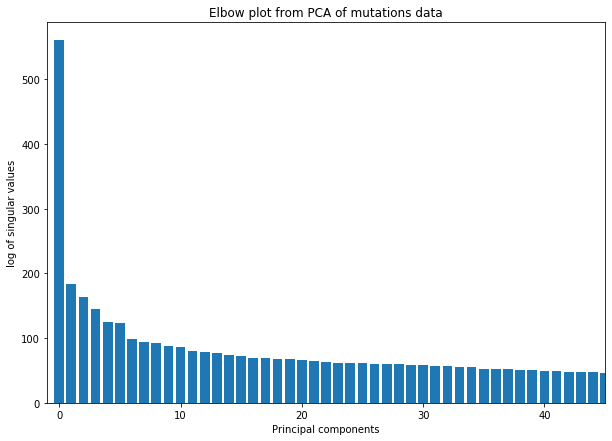

In [113]:
plt.figure(figsize=(10, 7))
plt.bar(x=range(pca.singular_values_.shape[0]), 
        height=pca.singular_values_, )

plt.ylabel('log of singular values')
plt.xlabel('Principal components')
plt.title('Elbow plot from PCA of mutations data')
plt.xlim(-1, 45)
# plt.ylim(0, 10)
plt.show()